<a href="https://colab.research.google.com/github/Romulo-Castro/IA-com-Criptomoeda/blob/main/TRABALHO_FINAL_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carregar os Dados da API


### Função para trazer os dados da Api

In [1]:
import numpy as np
from datetime import datetime, timedelta
import requests

def get_crypto_data(product_id, start_date, end_date, granularity):
  url = f"https://api.exchange.coinbase.com/products/{product_id}/candles"

  # Delta = Incremento entre uma candle e outra
  delta = timedelta(seconds=granularity)

  # Limitação da API
  max_candles = 300

  # Prevenir duplicações.
  current_date = datetime.strptime(start_date, '%Y-%m-%dT%H:%M:%S') - timedelta(seconds=1)
  end_date = datetime.strptime(end_date, '%Y-%m-%dT%H:%M:%S') - timedelta(seconds=1)

  results = []

  while current_date < end_date:
    next_date = current_date + max_candles * delta
    next_date = next_date if next_date < end_date else end_date

    params = {
        "start": current_date.isoformat(),
        "end": next_date.isoformat(),
        "granularity": granularity
    }

    headers = {"content-type": "application/json"}

    data = requests.get(url, params=params, headers=headers)
    data = data.json()

    results = data + results

    current_date = next_date

  columns = ['timestamp', "low", "high", "open", "close", "volume"]

  df = pd.DataFrame(data=results, columns=columns)

  # Tratamento da data.
  df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
  df.set_index('datetime', inplace=True)
  df.drop('timestamp', axis=1, inplace=True)

  return df


### Armazena os dados em um DataFrame do Pandas.

In [2]:
import pandas as pd
df = get_crypto_data(
  product_id="BTC-USD",
  start_date="2020-01-01T00:00:00",
  end_date="2024-01-01T00:00:00",
  granularity=86400
)

df = df.iloc[::-1]
df

,low,high,open,close,volume
datetime,,,,,
2020-01-01,7136.05,7238.14,7165.72,7174.33,3350.630049
2020-01-02,6903.00,7186.18,7174.33,6945.02,8010.927387
2020-01-03,6854.67,7401.20,6945.02,7334.45,14056.392385
2020-01-04,7263.32,7398.00,7334.45,7348.63,4742.466210
2020-01-05,7312.22,7488.87,7348.63,7355.40,5942.014946
...,...,...,...,...,...
2023-12-27,42111.47,43709.98,42521.21,43474.40,12917.484045
2023-12-28,42265.08,43830.34,43469.06,42581.23,13583.915998
2023-12-29,41300.00,43137.10,42581.23,42063.45,16756.433239


# Alimentar o modelo com os dados

### Criação dos conjuntos de dados para teste


In [3]:
from sklearn.preprocessing import MinMaxScaler

# Usar a coluna 'close' para a previsão
data = df['close'].values
data = data.reshape(-1, 1)

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Criar conjuntos de dados de treinamento e teste
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Verificar os tamanhos dos conjuntos de dados
print(f"Tamanho do conjunto de treinamento: {len(train_data)}")
print(f"Tamanho do conjunto de teste: {len(test_data)}")

Tamanho do conjunto de treinamento: 1168
Tamanho do conjunto de teste: 293


### Configurar os conjuntos de dados para serem treinados


In [4]:
# Função para criar datasets com sequência de passos
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Verificar os tamanhos dos conjuntos de dados criados
print(f"Tamanho do conjunto X_train: {X_train.shape}")
print(f"Tamanho do conjunto X_test: {X_test.shape}")

# Verificar se X_test está vazio
if X_test.size == 0:
    raise ValueError("X_test está vazio. Verifique o tamanho do conjunto de teste e o parâmetro look_back.")

# Reshape dos dados para [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Tamanho do conjunto X_train: (1107, 60)
Tamanho do conjunto X_test: (232, 60)


### Criação do modelo e Treinamento

In [5]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

# Criar e treinar o modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.fit(X_train, Y_train, batch_size=1, epochs=1)

# Fazer previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Desnormalizar as previsões
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Imprimir algumas previsões para verificação
print(f"\nPrevisões no conjunto de teste: {test_predict[:5]}\n")
print(f"Valores reais do conjunto de teste: {scaler.inverse_transform(Y_test[:5].reshape(-1, 1))}")

8/8 [==============================] - 0s 17ms/step

Previsões no conjunto de teste: [[28054.357]
 [27750.215]
 [27511.56 ]
 [27366.457]
 [27273.498]]

Valores reais do conjunto de teste: [[26789.48]
 [26929.98]
 [27171.13]
 [27037.68]
 [27407.77]]


# Exibir os Resultados

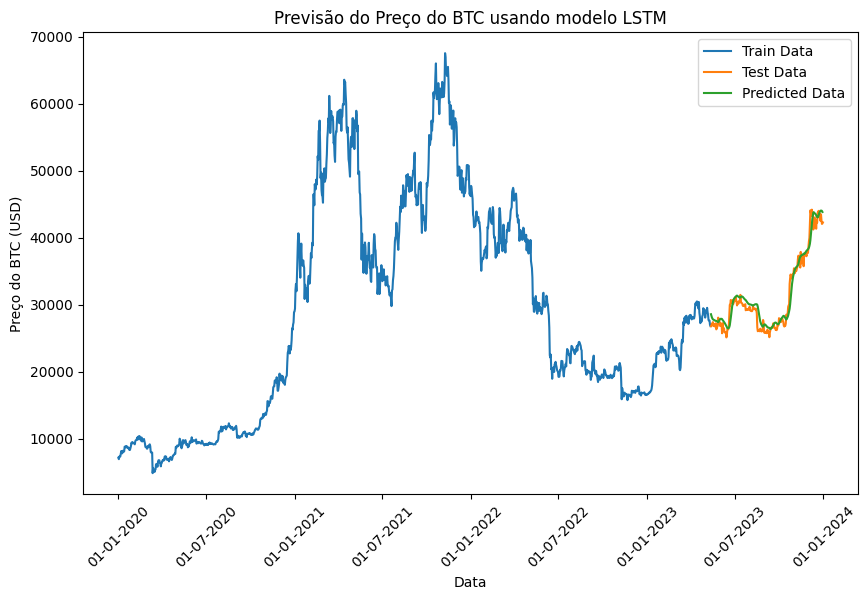

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Plotar resultados
train = data[:train_size + look_back]
test = data[train_size + look_back:]

# Criar índices de data para os conjuntos de treinamento e teste
train_dates = df.index[:train_size + look_back]
test_dates = df.index[train_size + look_back:]

# Plotar
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train, label='Train Data')
plt.plot(test_dates, test, label='Test Data')
plt.plot(test_dates[:-1], test_predict, label='Predicted Data')  # Remover último ponto para alinhar tamanhos
plt.xlabel('Data')
plt.ylabel('Preço do BTC (USD)')
plt.title('Previsão do Preço do BTC usando modelo LSTM')
plt.legend()
plt.xticks(rotation=45)  # Rotacionar rótulos do eixo x para melhor legibilidade
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))  # Formatar datas
plt.show()